# Machine Learning Project Checklist

1. Frame the problem and look at the big picture.

2. Get the data.

3. Explore the data to gain insights.

4. Explore many different models and short-list the best ones.

5. Fine-tune your models and combine them into a great solution.

6. Present your solution.

### Objective

Build an **intuitive** Machine Learning model to evaluate fair offer price of the given property in Budapest
- Dependent variable (predicted): **Price per squaremeter**
- Explanatory variables (features): GPS coordinates (**Latitude**, **Longitude**)

In [1]:
import os
REPO_DIR = os.path.join(os.environ['USERPROFILE'], 'repos')
PROJ_DIR = os.path.join(REPO_DIR, 'real_estate_machine_learning')
os.chdir(PROJ_DIR)

In [2]:
DATA_DIR = './data'
INT_DIR = os.path.join(DATA_DIR, 'interim')
PRO_DIR = os.path.join(DATA_DIR, 'processed')
MODEL_DIR = './model'
TMP_DIR = os.path.join(MODEL_DIR, 'tmp')
TRAIN_SALE_FN = 'training_sale_20181101.csv'
TEST_SALE_FN = 'testing_sale_20181101.csv'
TRAIN_CLASS_FN = 'training_class_20181101.csv'

In [4]:
import pandas as pd, numpy as np
import datetime
import tensorflow as tf
import tensorboard as tb
from src.processing import split_train_test_by_hash

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.contrib.learn import DNNRegressor

In [7]:
from sklearn.linear_model import LinearRegression, LogisticRegression

Load datasets:

In [8]:
train_sale = pd.read_csv(os.path.join(PRO_DIR, TRAIN_SALE_FN), encoding='utf8')

In [9]:
train_sale.columns

Index(['address', 'accessibility', 'ceiling_height', 'buses', 'buses_count',
       'furnished', 'desc', 'city_district', 'smoking', 'floors',
       'energy_perf_cert', 'balcony', 'bath_and_wc', 'type_of_heating',
       'equipped', 'boats', 'boats_count', 'local_railways',
       'local_railways_count', 'condition_of_real_estate',
       'with_entry_to_garden', 'view', 'pets', 'convenience_level', 'vacant',
       'residental_park_name', 'lat', 'lift', 'lng', 'air_conditioned',
       'metro_lines', 'metro_lines_count', 'min_tenancy', 'panelprogram',
       'parking', 'price_in_huf', 'area_size', 'utilities', 'attic',
       'trolley_buses', 'trolley_buses_count', 'listing_type', 'orientation',
       'trams', 'trams_count', 'all_night_services',
       'all_night_services_count', 'year_built', 'building_floors',
       'timestamp', 'elevation', 'room_lt_12_sqm', 'room_ge_12_sqm',
       'room_total', 'parking_lot_in_huf', 'parking_lot_in_eur',
       'parking_lot_in_huf_monthly', 'p

In [10]:
train_sale['log_price_in_huf'] = np.log(train_sale.price_in_huf)

In [11]:
train_class = pd.read_csv(os.path.join(PRO_DIR, TRAIN_CLASS_FN), encoding='utf8')

In [12]:
train_class['inhabited'] = (train_class.label == 'inhabited_budapest') *1

In [13]:
train_class.head()

,lat,lng,label,label_factor,inhabited
0,47.513012,19.057450,inhabited_budapest,0,1
1,47.581464,19.103602,inhabited_budapest,0,1
2,47.529426,19.125456,inhabited_budapest,0,1
3,47.501567,19.062093,inhabited_budapest,0,1
4,47.512733,19.125820,inhabited_budapest,0,1


In [14]:
class Linear:
    
    def __init__(self, batch_size = np.inf, n_epochs = 1000, learning_rate = 0.01, echo = True):
        
        self._batch_size = batch_size
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.echo = echo
        
    def fit(self, input_X, input_Y, checkpoint_path = None, log = False):
        
        now = datetime.datetime.utcnow().strftime('%Y%m%d%H%M%S')
        root_logdir = 'tf_logs'
        logdir = '{}/run-{}/'.format(root_logdir, now)
        
        m, n = input_X.shape
        input_X = np.concatenate([np.ones(shape=(m, 1)), input_X], axis=1)
        self.batch_size = int(np.minimum(m, self._batch_size))
        n_batches = int(np.ceil(m/self.batch_size))
        
        X = tf.placeholder(tf.float32, name='X')
        y = tf.placeholder(tf.float32, name='y')
        weights = tf.Variable(tf.random_uniform(shape=(n+1, 1), minval=-1, maxval=1, dtype=tf.float32), name='weights')
        y_pred = tf.matmul(a=X, b=weights)
        with tf.name_scope('loss'):
            error = y - y_pred
            sqd_error = tf.square(error)
            mse = tf.reduce_mean(sqd_error, name='mse')
        gradients = tf.gradients(mse, [weights])[0]
        training_op = tf.assign(weights, weights - self.learning_rate * gradients)
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        with tf.name_scope('summary'):
            mse_summary = tf.summary.scalar('MSE', mse)
            file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(self.n_epochs):
                for batch in range(n_batches):
                    idx = np.random.choice(m, size = self.batch_size, replace=False)
                    if batch % 10:
                        summary_str = mse_summary.eval(feed_dict={X: input_X[idx,], y: input_Y[idx,]})
                        step = epoch * n_batches + batch
                        file_writer.add_summary(summary_str, step)
                    sess.run(training_op, feed_dict={X: input_X[idx,], y: input_Y[idx,]})
                    
            best_weigths = weights.eval()
            self.weights = best_weigths
        file_writer.close()
        
    def fit_w_optimizer(self, X, Y):
        m, n = X.shape
        X = tf.constant(np.concatenate([np.ones(shape=(m,1)), X], axis=1), dtype=tf.float32, name='X')
        y = tf.constant(Y, dtype=tf.float32, name='y')
        weights = tf.Variable(tf.random_uniform(shape=(n+1, 1), minval=-1, maxval=1, dtype=tf.float32), name='weights')
        y_pred = tf.matmul(a=X, b=weights)
        error = y - y_pred
        sqd_error = tf.square(error)
        mse = tf.reduce_mean(sqd_error, name='mse')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(mse)
        init = tf.global_variables_initializer()
        
        
        with tf.Session() as sess:
            sess.run(init)

            for epoch in range(self.n_epochs):
                if epoch % 100 == 0:
                    if self.echo :
                        print("Epoch", epoch, "MSE =", mse.eval())
                sess.run(training_op)

            best_weigths = weights.eval()
            self.weights = best_weigths
    
    def predict(self, X):
        m, n = X.shape
        X = tf.constant(np.concatenate([np.ones(shape=(m,1)), X], axis=1), dtype=tf.float32, name='X')
        weights = tf.constant(self.weights, name='weights')
        y_pred = tf.matmul(a=X, b=weights)

        with tf.Session() as sess:
            return y_pred.eval()

In [15]:
class Logistic:
    
    def __init__(self, batch_size = np.inf, n_epochs = 1000, learning_rate = 0.01, echo = True):
        
        self._batch_size = batch_size
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.echo = echo
        
    def fit(self, input_X, input_Y, checkpoint_path = None, log = False):
        
        now = datetime.datetime.utcnow().strftime('%Y%m%d%H%M%S')
        root_logdir = 'tf_logs'
        logdir = '{}/run-{}/'.format(root_logdir, now)
        
        m, n = input_X.shape
        m, n_labels = input_Y.shape
        input_X_with_bias = np.concatenate([np.ones(shape=(m, 1)), input_X], axis=1)
        self.batch_size = int(np.minimum(m, self._batch_size))
        n_batches = int(np.ceil(m/self.batch_size))
        
        X = tf.placeholder(tf.float32, shape=(None, n+1), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, n_labels), name='Y')
        weights = tf.Variable(tf.random_uniform(shape=(n+1, n_labels), minval=-1, maxval=1, dtype=tf.float32), name='weights')
        score = tf.matmul(a=X, b=weights)
        prob = 1/(1+tf.exp(-score))
#         exp_score = tf.exp(score)
#         prob = exp_score/tf.reduce_sum(input_tensor=exp_score, axis=1)

        log_loss = -tf.reduce_mean(tf.log(prob+1e-7) * Y + tf.log(prob+1e-7) * (1 - Y) )
#         log_loss = -tf.reduce_mean(tf.log(tf.reduce_sum(prob * Y, axis=1)))
        gradients = tf.gradients(log_loss, [weights])[0]
        training_op = tf.assign(weights, weights - self.learning_rate * gradients)
        init = tf.global_variables_initializer()
#         saver = tf.train.Saver()
#         with tf.name_scope('summary'):
#             mse_summary = tf.summary.scalar('MSE', mse)
#             file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(self.n_epochs):
                idx = np.random.choice(m, size = self.batch_size, replace=False)
                sess.run(training_op, feed_dict={X: input_X_with_bias[idx,], Y: input_Y[idx,]})
                if epoch % 100 == 0:
                    if self.echo :
                        print("Epoch", epoch, "logloss =", log_loss.eval(feed_dict={X: input_X_with_bias[idx,], Y: input_Y[idx,]}))
            best_weigths = weights.eval()
            self.weights = best_weigths
#         file_writer.close()
    
    def predict(self, X):
        m, n = X.shape
        X = tf.constant(np.concatenate([np.ones(shape=(m,1)), X], axis=1), dtype=tf.float32, name='X')
        weights = tf.constant(self.weights, name='weights')
        y_pred = tf.matmul(a=X, b=weights)

        with tf.Session() as sess:
            return y_pred.eval()

In [16]:
scaler = StandardScaler()

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [19]:
st_train_sale = scaler.fit_transform(train_sale[['lat', 'lng', 'price_per_sqm']].values)

In [102]:
input_X = st_train_sale[:,:2]
# input_Y = train_sale[['price_per_sqm']].values
input_Y = st_train_sale[:,-1:]

m = len(train_sale)
n_inputs = 2
n_hidden1 = 5
# n_hidden2 = 50
# n_hidden3 = 25
# n_hidden4 = 10
# n_hidden5 = 5
n_outputs = 1

X = tf.placeholder(dtype=tf.float64, shape=(None, n_inputs), name='X')
Y = tf.placeholder(dtype=tf.float64, shape=(None, n_outputs), name='Y')

with tf.variable_scope("dnn"):
#     hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
#                               activation=tf.nn.relu)
#     hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
#                               activation=tf.nn.relu)
#     hidden3 = tf.layers.dense(hidden2, n_hidden3, name="hidden3",
#                               activation=tf.nn.relu)
#     hidden4 = tf.layers.dense(hidden3, n_hidden4, name="hidden4",
#                               activation=tf.nn.relu)
#     hidden5 = tf.layers.dense(hidden4, n_hidden5, name="hidden5",
#                               activation=tf.nn.relu)
    Y_pred = tf.layers.dense(X, n_outputs, name="outputs")
#     Y_pred = tf.layers.dense(hidden1, n_outputs, name="outputs")
 
with tf.name_scope('loss'):
    error = Y_pred - Y
    sse = tf.reduce_sum(tf.square(error), name='sse')
    mse = tf.reduce_mean(tf.square(error), name='mse')
    sst = tf.reduce_sum(tf.square(Y - tf.reduce_mean(Y)), name='sst')
    r2 = 1 -(sse/sst)

learning_rate = 0.01

with tf.name_scope("train"):
#     optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(mse)

# with tf.variable_scope("outputs", reuse=True):
#     weights = tf.get_variable("kernel")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(m // batch_size):
            idx = np.random.choice(m, size = batch_size, replace=False)
            X_batch, Y_batch = input_X[idx,], input_Y[idx,]
            sess.run(training_op, feed_dict={X:  X_batch, Y: Y_batch})
            acc_train = r2.eval(feed_dict={X:  X_batch, Y: Y_batch})
        if epoch % 100==0:
#             if epoch % 100==0:
            print(epoch, "Train accuracy:", acc_train)
                
#     save_path = saver.save(sess, "/tmp/my_model_.ckpt")

0 Train accuracy: -4.630564407234507
100 Train accuracy: 0.1971640994815489
200 Train accuracy: 0.17495443586864212
300 Train accuracy: 0.1515658798543168
400 Train accuracy: 0.17223496604472455
500 Train accuracy: 0.14761744813473632
600 Train accuracy: 0.18164319167556486
700 Train accuracy: 0.1754994026275032
800 Train accuracy: 0.14100259342963206
900 Train accuracy: 0.16649453313334328


In [120]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [23]:
st_train_sale

array([[-0.4314814 , -0.17981517, -0.39283519],
       [ 0.24762311,  0.04552419, -0.49742046],
       [ 0.24636657,  0.04410701, -0.50993871],
       ...,
       [ 0.12393181, -0.36758066,  0.0463655 ],
       [ 0.06966471, -0.07525533, -0.61528208],
       [-0.03017184, -0.14991337,  0.64276013]])

In [24]:
st_train_sale[:,:2]

array([[-0.4314814 , -0.17981517],
       [ 0.24762311,  0.04552419],
       [ 0.24636657,  0.04410701],
       ...,
       [ 0.12393181, -0.36758066],
       [ 0.06966471, -0.07525533],
       [-0.03017184, -0.14991337]])

In [39]:
input_X, input_Y = st_train_sale[:,:2], st_train_sale[:,2:]

In [57]:
learning_curve = {'training':[], 'validation': []}

now = datetime.datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now)

n_epochs = 20000
batch_size = 2000

train_X, val_X, train_Y, val_Y = train_test_split(input_X, input_Y, test_size=0.2, random_state=777)

m = len(train_X)
n_batches = int(np.ceil(m/batch_size))

n_inputs = 2
n_hidden1 = 300
n_hidden2 = 250
n_hidden3 = 200
n_hidden4 = 150
n_hidden5 = 100
n_hidden6 = 50
n_outputs = 1

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float64, name='X')
Y = tf.placeholder(shape=(None, n_outputs), dtype=tf.float64, name='Y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs=X, units=n_hidden1, name='hidden1', activation=tf.nn.elu)
    hidden2 = tf.layers.dense(inputs=hidden1, units=n_hidden2, name='hidden2', activation=tf.nn.elu)
    hidden3 = tf.layers.dense(inputs=hidden2, units=n_hidden3, name='hidden3', activation=tf.nn.elu)
    hidden4 = tf.layers.dense(inputs=hidden3, units=n_hidden4, name='hidden4', activation=tf.nn.elu)
    hidden5 = tf.layers.dense(inputs=hidden4, units=n_hidden5, name='hidden5', activation=tf.nn.elu)
    hidden6 = tf.layers.dense(inputs=hidden5, units=n_hidden6, name='hidden6', activation=tf.nn.elu)
    Y_pred = tf.layers.dense(inputs=hidden5, units=n_outputs, name='outputs')

with tf.name_scope(name='loss'):
    error =tf.subtract(Y, Y_pred, name='error')
    sq_error = tf.square(error, name='sq_error')
    mse = tf.reduce_mean(sq_error, name='mse') # possible to add regularization l1, l2
#     mse = tf.multiply(sse, 1/m)

with tf.name_scope(name='r2'):
    Y_mean = tf.reduce_mean(Y, name='Y_mean')
    sst = tf.reduce_sum(tf.square(Y - Y_mean))
    sse = tf.reduce_sum(sq_error, name='sse')
    r_sq = 1 - (sse/sst)

with tf.name_scope(name='summary'):
    mse_summary = tf.summary.scalar(name='MSE', tensor=mse)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

learning_rate = 0.01
with tf.name_scope(name='train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
    training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=40)

with tf.Session() as sess:
    sess.run(init)
    train_batches_X, train_batches_Y = np.array_split(train_X, n_batches), np.array_split(train_Y, n_batches)
    for epoch in range(n_epochs):
        for iteration, train_batch_X, train_batch_Y in zip(range(n_batches), train_batches_X, train_batches_Y):
            rnd_idx = np.random.choice(m, size = batch_size, replace=False)
            train_batch_X, train_batch_Y = train_X[rnd_idx,], train_Y[rnd_idx,]
            sess.run(training_op, feed_dict={X: train_batch_X, Y: train_batch_Y})
            if iteration % 10 ==0:
                learning_curve['training'].append(mse.eval(feed_dict={X: train_batch_X, Y: train_batch_Y}))
                learning_curve['validation'].append(mse.eval(feed_dict={X: val_X, Y: val_Y}))
        if epoch % 500 == 0:
            train_r_sq = r_sq.eval(feed_dict={X: train_batch_X, Y: train_batch_Y})
            val_r_sq = r_sq.eval(feed_dict={X: val_X, Y: val_Y})
            print('Epoch: {0}, Training acc: {1}, Validation acc: {2}'.format(epoch, train_r_sq, val_r_sq))
            saver_path = saver.save(sess=sess, save_path='./model/tf/model_epoch_{0}.ckpt'.format(epoch))
    saver_path = saver.save(sess=sess, save_path='./model/tf/model_epoch_{0}.ckpt'.format(epoch))

Epoch: 0, Training acc: 0.11529943705204737, Validation acc: 0.12173415871470217
Epoch: 500, Training acc: 0.3497360750836712, Validation acc: 0.3414561655070527
Epoch: 1000, Training acc: 0.3904487563174197, Validation acc: 0.3957298218042411
Epoch: 1500, Training acc: 0.4666692105853998, Validation acc: 0.4273678991379498
Epoch: 2000, Training acc: 0.4669929437897624, Validation acc: 0.43822159179954423
Epoch: 2500, Training acc: 0.48188740869871416, Validation acc: 0.4477086756613422
Epoch: 3000, Training acc: 0.4802043560626389, Validation acc: 0.4486767797828377
Epoch: 3500, Training acc: 0.4387709684536052, Validation acc: 0.4541719975634626
Epoch: 4000, Training acc: 0.4446749012693826, Validation acc: 0.4359864370482033
Epoch: 4500, Training acc: 0.45062220380523554, Validation acc: 0.4573078692903586
Epoch: 5000, Training acc: 0.4806932600455188, Validation acc: 0.4507179533561617
Epoch: 5500, Training acc: 0.5009117114591, Validation acc: 0.45841602486002975
Epoch: 6000, Trai

In [56]:
tf.reset_default_graph()

In [54]:
a = learning_curve.copy()

In [48]:
import matplotlib.pyplot as plt

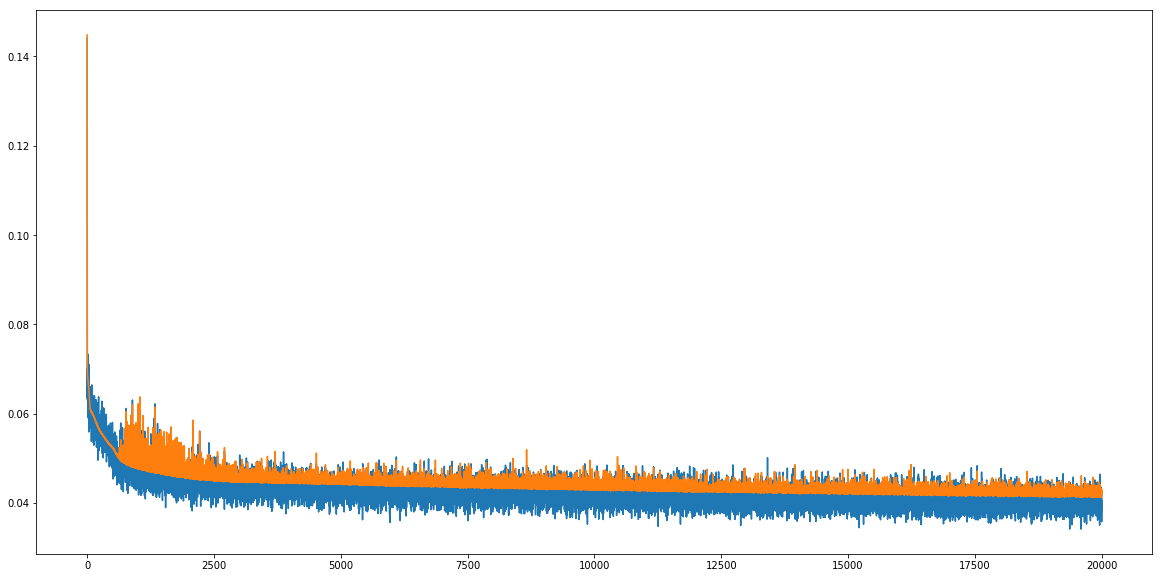

In [55]:
fig = plt.gcf()
fig.set_size_inches((20,10))
plt.plot(range(len(a['training'])), a['training'])
plt.plot(range(len(a['validation'])), a['validation'])
plt.show()